## Autophagy Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

#Statistical Analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import display, HTML
%matplotlib inline
%config IPCompleter.greedy=True

## Aggregate cohort group table and RNA Ct value excel files

In [2]:
#paste Mouse Grouping as you defines structure in Prism
#group_columns = ['Group','id']
B77_group_tbl = pd.read_csv("B77-group.csv", 
                        sep=',',
                       dtype={"group":str, "id":str})
B77_group_tbl = B77_group_tbl.dropna()

def aggregateTimepoints(cohort_excel_file, cohort_group_tbl):
    cohort_excel = pd.ExcelFile(cohort_excel_file)
    cohort_sheets = cohort_excel.sheet_names
    df_timepoints = pd.DataFrame()
    for i in cohort_sheets:
        df = pd.read_excel(cohort_excel,i)
        df['id'] = df['id'].astype(str)
        #df['plate info'] = df['plate info'].astype(str)
        #df['Target'] = df['Target'].astype(float)
        path_file_name = "data\\" + i + '.csv'
        df.to_csv(path_file_name)
        
        #Need to consolidate multiple rows to column 
        df = df.pivot_table(values='Ct', index=['id'], columns=['Target'])
        #merge with Animal Group table
        df = cohort_group_tbl.merge(df, on='id',how='left')
        #assign to time point column and rearrange
        df['time-point'] = i
        df= df.reindex(columns=['id','Group','time-point','HPRT1','MX1','IRF7','OAS1'])

        #Calculate Ct ratio for all targets
        df['MX1 Ct ratio'] = df['MX1'].div(df['HPRT1'], axis ="index") # normalize by HPRT1
        df['IRF7 Ct ratio'] = df['IRF7'].div(df['HPRT1'], axis ="index") # normalize by HPRT1
        df['OAS1 Ct ratio'] = df['OAS1'].div(df['HPRT1'], axis ="index") # normalize by HPRT1
        
        df['MX1 Ct log'] = -np.log(df['MX1 Ct ratio'])  # negative log transformation scale
        df['IRF7 Ct log'] = -np.log(df['IRF7 Ct ratio'])  # negative log transformation scale
        df['OAS1 Ct log'] = -np.log(df['OAS1 Ct ratio'])  # negative log transformation scale
        
        #locate control
        df_control = df.loc[df['Group'] == 'uninfected control']
        controlAvgRef_Mean = df_control['HPRT1'].mean()
        controlAvgTarget_MX1_Mean = df_control['MX1'].mean()
        controlAvgTarget_IRF7_Mean = df_control['IRF7'].mean()
        controlAvgTarget_OAS1_Mean = df_control['OAS1'].mean()
        
        # normailze delta Ct = MX1 of sample - average value MX1 of uninfected samples
        column_list =['delta MX1','delta HPRT1','delta-delta MX1','Fold Change MX1',
                                      'delta IRF7','delta-delta IRF7','Fold Change IRF7',
                                      'delta OAS1','delta-delta OAS1','Fold Change OAS1']
        df = df.reindex(columns=[*df.columns.tolist(), *column_list], fill_value=0.0)
        
        
        df['delta HPRT1'] = df['HPRT1'] - controlAvgRef_Mean
        df['delta MX1'] = df['MX1'] - controlAvgTarget_MX1_Mean        
        df['delta IRF7'] = df['IRF7'] - controlAvgTarget_IRF7_Mean        
        df['delta OAS1'] = df['OAS1'] - controlAvgTarget_OAS1_Mean        
        
        
        df['delta-delta MX1'] = df['delta MX1'] - df['delta HPRT1']
        df['delta-delta IRF7'] = df['delta IRF7'] - df['delta HPRT1']
        df['delta-delta OAS1'] = df['delta OAS1'] - df['delta HPRT1']
        
        df['Fold Change MX1'] = 2 ** -df['delta-delta MX1']
        df['Fold Change IRF7'] = 2 ** -df['delta-delta IRF7']
        df['Fold Change OAS1'] = 2 ** -df['delta-delta OAS1']
        
        
        df_timepoints = df_timepoints.append(df)
        
    #df_timepoints = df_timepoints.dropna(subset=['HPRT1'])
    df_timepoints = df_timepoints.reset_index(drop=True)
    return df_timepoints

def saveExcelSheets(df,filename):
    grouped = df_B77.groupby('time-point',sort=True)
    with pd.ExcelWriter(filename) as writer:
        for timepoint, df_timepoint in grouped:
            df_timepoint.to_excel(writer, sheet_name=timepoint, index=False)
        
    

In [3]:
df_B77 = aggregateTimepoints(cohort_excel_file = 'data\B77 RNA Ct.xlsx', cohort_group_tbl = B77_group_tbl)
saveExcelSheets(df_B77, filename='data\B77 RNA Ct_groupby_timepoints.xlsx')
        
df_B77

,id,Group,time-point,HPRT1,MX1,IRF7,OAS1,MX1 Ct ratio,IRF7 Ct ratio,OAS1 Ct ratio,...,delta MX1,delta HPRT1,delta-delta MX1,Fold Change MX1,delta IRF7,delta-delta IRF7,Fold Change IRF7,delta OAS1,delta-delta OAS1,Fold Change OAS1
0,1,uninfected control,Bleed 9-9,32.173135,31.074580,29.965935,32.242414,0.965855,0.931396,1.002153,...,0.563967,-0.309846,0.873813,0.545703,0.394989,0.704835,0.613512,0.801842,1.111688,0.462752
1,2,uninfected control,Bleed 9-9,31.729858,30.677746,29.386741,31.951558,0.966842,0.926154,1.006987,...,0.167133,-0.753124,0.920257,0.528415,-0.184205,0.568918,0.674122,0.510985,1.264109,0.416356
2,3,uninfected control,Bleed 9-9,33.094995,30.720028,29.911511,31.743166,0.928238,0.903808,0.959153,...,0.209415,0.612014,-0.402599,1.321887,0.340565,-0.271448,1.207019,0.302594,-0.309420,1.239209
3,4,uninfected control,Bleed 9-9,32.309570,30.877406,30.062531,31.720836,0.955674,0.930453,0.981778,...,0.366793,-0.173411,0.540204,0.687674,0.491585,0.664996,0.630690,0.280263,0.453675,0.730181
4,5,uninfected control,Bleed 9-9,33.107349,29.203306,28.528012,29.544888,0.882079,0.861682,0.892397,...,-1.307307,0.624368,-1.931675,3.814979,-1.042934,-1.667302,3.176200,-1.895684,-2.520052,5.736028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,28,rapamycin + HIV,Bleed 11-3,32.051349,30.412807,30.391273,30.994584,0.948878,0.948206,0.967029,...,1.752127,1.198428,0.553699,0.681271,1.467531,0.269103,0.829835,1.205011,0.006584,0.995447
141,29,spermidine + HIV,Bleed 11-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,31,rapamycin + HIV,Bleed 11-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,32,spermidine + HIV,Bleed 11-3,33.636573,31.428415,31.526297,31.411761,0.934352,0.937262,0.933857,...,2.767735,2.783651,-0.015916,1.011093,2.602555,-0.181096,1.133745,1.622189,-1.161462,2.236840


Look at B77 dataset

In [ ]:
result = df_B77['Fold Change MX1'] > 4
#display(HTML(df_B77[result].to_html()))

## Graph all the time-points in a plot using Ct ratio and ΔΔCt value

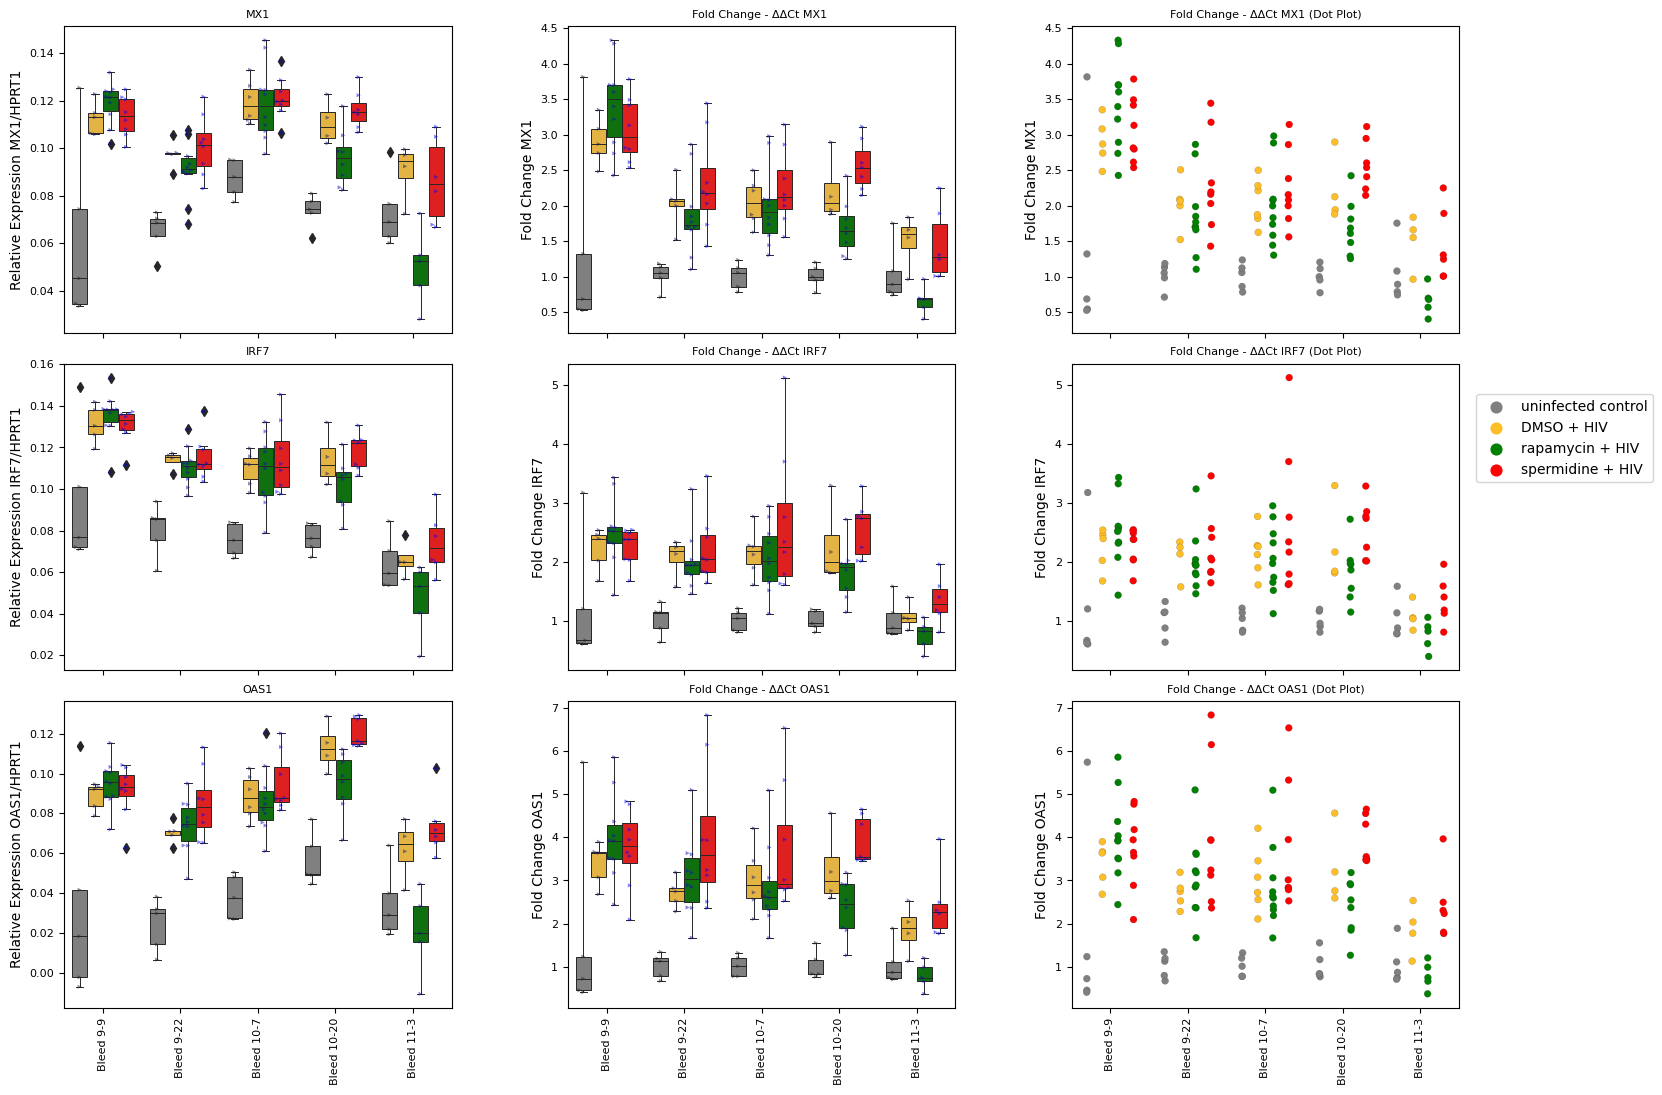

In [4]:
np.warnings.filterwarnings('ignore')

order_list = ['uninfected control', 'DMSO + HIV', 'rapamycin + HIV', 'spermidine + HIV']
paletteColor = {'uninfected control' : 'grey',
               'DMSO + HIV': '#FEBE28',
               'rapamycin + HIV': 'green',
               'spermidine + HIV':'red'}


fig = plt.figure(figsize = (18, 13), dpi= 100)
fig.subplots_adjust(hspace=0.1, wspace=0.3)

ax = fig.add_subplot(3, 3, 1)
sns.boxplot(x = "time-point", y = "MX1 Ct log", data = df_B77, hue ='Group',hue_order = order_list, 
            palette=paletteColor, showfliers=True, linewidth=0.7, ax=ax)
sns.swarmplot(x = "time-point", y = "MX1 Ct log", data = df_B77, hue ='Group', hue_order = order_list,
                     marker='>',color='blue',alpha=0.5,dodge=True, size=3, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelbottom=False)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("MX1", fontsize = 8)
ax.get_legend().remove()
ax.set_xlabel('')
ax.set_ylabel('Relative Expression MX1/HPRT1')


ax = fig.add_subplot(3, 3, 2)
sns.boxplot(x = "time-point", y = "Fold Change MX1", data = df_B77, hue ='Group', hue_order = order_list, 
                     palette=paletteColor, whis = 95, showfliers=True, linewidth=0.7, ax=ax)

sns.swarmplot(x = "time-point", y = "Fold Change MX1", data = df_B77, hue ='Group', hue_order = order_list,
                     marker='>',color='blue',alpha=0.5,dodge=True, size=3, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelbottom=False)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("Fold Change - ΔΔCt MX1 ", fontsize = 8)
ax.get_legend().remove()
ax.set_xlabel('')

ax = fig.add_subplot(3, 3, 3)
# #use log scale
# ax.set_yscale("symlog")
# sns.boxplot(x = "time-point", y = "MX1 Ct ratio", data = df_B77, hue ='Group',hue_order = order_list, 
#             palette=paletteColor, showfliers=True, linewidth=0.7, ax=ax)
# sns.swarmplot(x = "time-point", y = "MX1 Ct ratio", data = df_B77, hue ='Group', hue_order = order_list,
#                      marker='>',color='blue',alpha=0.5,dodge=True, size=3, ax=ax)

# # invert log at Y axis
# ax.invert_yaxis()


sns.stripplot(x = "time-point", y = "Fold Change MX1", data = df_B77, hue ='Group',hue_order = order_list,
                     palette=paletteColor, linewidth=0.1, jitter=0.03, dodge=True, size=5, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelbottom=False)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("Fold Change - ΔΔCt MX1 (Dot Plot)", fontsize = 8)
#ax.legend(loc = "lower left", fontsize = 'x-small');
ax.get_legend().remove()
ax.set_xlabel('')

#-------------------------    IRF7  --------------------------------------------------

ax = fig.add_subplot(3, 3, 4)
sns.boxplot(x = "time-point", y = "IRF7 Ct log", data = df_B77, hue ='Group',hue_order = order_list, 
            palette=paletteColor, showfliers=True, linewidth=0.7, ax=ax)
sns.swarmplot(x = "time-point", y = "IRF7 Ct log", data = df_B77, hue ='Group', hue_order = order_list,
                     marker='>',color='blue',alpha=0.5,dodge=True, size=3, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelbottom=False)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("IRF7", fontsize = 8)
ax.get_legend().remove()
ax.set_xlabel('')
ax.set_ylabel('Relative Expression IRF7/HPRT1')

ax = fig.add_subplot(3, 3, 5)
sns.boxplot(x = "time-point", y = "Fold Change IRF7", data = df_B77, hue ='Group', hue_order = order_list, 
                     palette=paletteColor, whis = 95, showfliers=True, linewidth=0.7, ax=ax)

sns.swarmplot(x = "time-point", y = "Fold Change IRF7", data = df_B77, hue ='Group', hue_order = order_list,
                     marker='>',color='blue',alpha=0.5,dodge=True, size=3, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelbottom=False)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("Fold Change - ΔΔCt IRF7 ", fontsize = 8)
ax.get_legend().remove()
ax.set_xlabel('')

ax = fig.add_subplot(3, 3, 6)
sns.stripplot(x = "time-point", y = "Fold Change IRF7", data = df_B77, hue ='Group',hue_order = order_list,
                     palette=paletteColor, linewidth=0.1, jitter=0.03, dodge=True, size=5, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelbottom=False)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("Fold Change - ΔΔCt IRF7 (Dot Plot)", fontsize = 8)
#ax.legend(loc = "lower left", fontsize = 'x-small');
ax.get_legend().remove()
ax.set_xlabel('')


#-------------------------    OAS1  --------------------------------------------------

ax = fig.add_subplot(3, 3, 7)
sns.boxplot(x = "time-point", y = "OAS1 Ct log", data = df_B77, hue ='Group',hue_order = order_list, 
            palette=paletteColor, showfliers=True, linewidth=0.7, ax=ax)
sns.swarmplot(x = "time-point", y = "OAS1 Ct log", data = df_B77, hue ='Group', hue_order = order_list,
                     marker='>',color='blue',alpha=0.5,dodge=True, size=3, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 8)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("OAS1", fontsize = 8)
ax.get_legend().remove()
ax.set_xlabel('')
ax.set_ylabel('Relative Expression OAS1/HPRT1')

ax = fig.add_subplot(3, 3, 8)

sns.boxplot(x = "time-point", y = "Fold Change OAS1", data = df_B77, hue ='Group', hue_order = order_list, 
                     palette=paletteColor, whis = 95, showfliers=False, linewidth=0.7, ax=ax)
# sns.boxplot(x = "time-point", y = "Fold Change OAS1", data = df_B77, hue ='Group', hue_order = order_list, showmeans=True, 
#             medianprops={"median":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"2"},
#                      palette=paletteColor, whis = 95, showfliers=True, linewidth=0.7, ax=ax)

sns.swarmplot(x = "time-point", y = "Fold Change OAS1", data = df_B77, hue ='Group', hue_order = order_list,
                     marker='>',color='blue',alpha=0.5,dodge=True, size=3, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 8)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("Fold Change - ΔΔCt OAS1 ", fontsize = 8)
ax.get_legend().remove()
ax.set_xlabel('')

ax = fig.add_subplot(3, 3, 9)
sns.stripplot(x = "time-point", y = "Fold Change OAS1", data = df_B77, hue ='Group',hue_order = order_list,
                     palette=paletteColor, linewidth=0.1, jitter=0.03, dodge=True, size=5, ax=ax)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 8)
ax.tick_params(axis = 'y', labelsize = 8)
ax.set_title("Fold Change - ΔΔCt OAS1 (Dot Plot)", fontsize = 8)
#ax.legend(loc = "lower left", fontsize = 'x-small');
#ax.get_legend().remove()
ax.set_xlabel('')

plt.legend(bbox_to_anchor=(1.5, 2),borderaxespad=0, fontsize = 'medium')
#plt.grid(True)
#plt.savefig('B77_RNA.png', dpi=200, bbox_inches='tight', pad_inches=0.5)
#plt.tight_layout()
plt.show()


## Look at Fold Chang OAS1>4

In [5]:
result = df_B77['Fold Change OAS1'] > 4
display(HTML(df_B77[result].to_html()))

,id,Group,time-point,HPRT1,MX1,IRF7,OAS1,MX1 Ct ratio,IRF7 Ct ratio,OAS1 Ct ratio,MX1 Ct log,IRF7 Ct log,OAS1 Ct log,delta MX1,delta HPRT1,delta-delta MX1,Fold Change MX1,delta IRF7,delta-delta IRF7,Fold Change IRF7,delta OAS1,delta-delta OAS1,Fold Change OAS1
4,5,uninfected control,Bleed 9-9,33.107349,29.203306,28.528012,29.544888,0.882079,0.861682,0.892397,0.125473,0.148869,0.113845,-1.307307,0.624368,-1.931675,3.814979,-1.042934,-1.667302,3.176200,-1.895684,-2.520052,5.736028
17,20,rapamycin + HIV,Bleed 9-9,31.935915,28.276279,27.810207,28.881196,0.885407,0.870813,0.904348,0.121708,0.138328,0.100541,-2.234334,-0.547066,-1.687268,3.220462,-1.760739,-1.213673,2.319273,-2.559376,-2.012310,4.034278
18,21,spermidine + HIV,Bleed 9-9,33.268235,29.648676,29.040141,29.973388,0.891201,0.872909,0.900961,0.115186,0.135924,0.104293,-0.861937,0.785253,-1.647191,3.132232,-0.530805,-1.316058,2.489849,-1.467185,-2.252438,4.764874
19,22,rapamycin + HIV,Bleed 9-9,35.032276,30.945171,30.387111,31.593070,0.883333,0.867403,0.901828,0.124053,0.142251,0.103332,0.434557,2.549294,-2.114737,4.331111,0.816165,-1.733130,3.324483,0.152498,-2.396797,5.266325
20,23,rapamycin + HIV,Bleed 9-9,32.903458,29.042351,28.647710,29.735303,0.882653,0.870660,0.903714,0.124823,0.138504,0.101243,-1.468262,0.420476,-1.888739,3.703113,-0.923236,-1.343713,2.538036,-1.705270,-2.125746,4.364288
22,26,rapamycin + HIV,Bleed 9-9,32.946642,28.875570,28.255783,29.355379,0.876434,0.857623,0.890998,0.131893,0.153591,0.115414,-1.635044,0.463661,-2.098705,4.283246,-1.315163,-1.778824,3.431464,-2.085194,-2.548855,5.851695
23,27,spermidine + HIV,Bleed 9-9,33.177582,29.285195,28.925848,30.072738,0.882680,0.871849,0.906417,0.124792,0.137139,0.098255,-1.225418,0.694601,-1.920019,3.784281,-0.645098,-1.339699,2.530985,-1.367834,-2.062435,4.176908
25,29,spermidine + HIV,Bleed 9-9,33.849720,30.384133,29.684039,30.536131,0.897618,0.876936,0.902109,0.108010,0.131321,0.103020,-0.126480,1.366738,-1.493219,2.815164,0.113093,-1.253645,2.384431,-0.904442,-2.271180,4.827179
47,21,spermidine + HIV,Bleed 9-22,33.958370,30.291685,30.148766,30.577371,0.892024,0.887815,0.900437,0.114262,0.118991,0.104875,0.610685,2.277605,-1.666920,3.175359,0.917650,-1.359955,2.566772,-0.341047,-2.618652,6.141758
48,22,rapamycin + HIV,Bleed 9-22,34.311605,30.862040,30.167318,31.200363,0.899464,0.879216,0.909324,0.105957,0.128724,0.095054,1.181040,2.630840,-1.449800,2.731702,0.936202,-1.694638,3.236956,0.281945,-2.348895,5.094338


In [ ]:
#df_result = df_B77.loc[(df_B77['Group'] == 'uninfected control') & (df_B77['time-point'] == 'Bleed 11-3')]
#display(HTML(df_result.to_html()))

In [6]:
df_result = df_B77.loc[(df_B77['time-point'] == 'Bleed 9-9')]
agg_list = {'Fold Change MX1' :['count','mean','std','min','max'],
            'Fold Change IRF7' :['count','mean','std','min','max'],
           'Fold Change OAS1' :['count','mean','std','min','max']}
#df_result.groupby('Group').agg(agg_list)

## One Way ANOVA analysis
We will test One Way ANOVA on MX1, IRF7 and OAS1 from Bleed 11-3 timepoint individually. 

First calculate one way ANOVA on MX1. And perform multiple pairwaise comparion using Tukey HSD method.

In [7]:
df_result = df_B77.loc[(df_B77['time-point'] == 'Bleed 11-3')]
df_result = df_result.dropna(subset=['HPRT1'])
cols = ['Group','Fold Change MX1']
df_result = df_result[cols]
df_result = df_result.reset_index(drop=True)
df_result.columns = ['treatments', 'value']

from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df_result, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,2.271609,0.757203,4.717715,0.015233
Residual,16.0,2.568033,0.160502,NaN,NaN


In [8]:
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res.tukey_hsd(df=df_result, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,uninfected control,DMSO + HIV,0.451435,-0.317522,1.220391,2.375547,0.366269
1,uninfected control,rapamycin + HIV,0.388190,-0.336790,1.113169,2.166649,0.443954
2,uninfected control,spermidine + HIV,0.399838,-0.294276,1.093953,2.330898,0.382315
3,DMSO + HIV,rapamycin + HIV,0.839624,0.070668,1.608581,4.418283,0.029984
4,DMSO + HIV,spermidine + HIV,0.051597,-0.688332,0.791525,0.282164,0.900000
5,rapamycin + HIV,spermidine + HIV,0.788028,0.093913,1.482142,4.593889,0.023444


 DMSO + HIV  ---  rapamycin + HIV    P-value <0.05<br />
 rapamycin + HIV --- spermidine + HIV   P-value <0.05

### Now perform same ANOVA test and pairwise for IRF7

In [9]:
df_result = df_B77.loc[(df_B77['time-point'] == 'Bleed 11-3')]
df_result = df_result.dropna(subset=['HPRT1'])
cols = ['Group','Fold Change IRF7']
df_result = df_result[cols]
df_result = df_result.reset_index(drop=True)
df_result.columns = ['treatments', 'value']

from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df_result, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,0.943287,0.314429,2.98069,0.0626
Residual,16.0,1.687819,0.105489,NaN,NaN


In [10]:
res.tukey_hsd(df=df_result, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,uninfected control,DMSO + HIV,0.048639,-0.574758,0.672035,0.315710,0.900000
1,uninfected control,rapamycin + HIV,0.274635,-0.313109,0.862379,1.890765,0.549971
2,uninfected control,spermidine + HIV,0.311001,-0.251721,0.873722,2.236338,0.417389
3,DMSO + HIV,rapamycin + HIV,0.323274,-0.300123,0.946670,2.098340,0.470338
4,DMSO + HIV,spermidine + HIV,0.262362,-0.337502,0.862225,1.769776,0.596080
5,rapamycin + HIV,spermidine + HIV,0.585635,0.022913,1.148357,4.211178,0.039937


### Now perform same ANOVA test and pairwise for OAS1

In [11]:
df_result = df_B77.loc[(df_B77['time-point'] == 'Bleed 11-3')]
df_result = df_result.dropna(subset=['HPRT1'])
cols = ['Group','Fold Change OAS1']
df_result = df_result[cols]
df_result = df_result.reset_index(drop=True)
df_result.columns = ['treatments', 'value']

from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df_result, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,9.000739,3.000246,8.589293,0.001257
Residual,16.0,5.588812,0.349301,NaN,NaN


In [12]:
res.tukey_hsd(df=df_result, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,uninfected control,DMSO + HIV,0.801602,-0.332785,1.935988,2.859352,0.221215
1,uninfected control,rapamycin + HIV,0.269146,-0.800364,1.338656,1.018294,0.882476
2,uninfected control,spermidine + HIV,1.359163,0.335185,2.383141,5.370951,0.007734
3,DMSO + HIV,rapamycin + HIV,1.070748,-0.063639,2.205134,3.819409,0.067828
4,DMSO + HIV,spermidine + HIV,0.557562,-0.534003,1.649126,2.066873,0.482546
5,rapamycin + HIV,spermidine + HIV,1.628309,0.604331,2.652287,6.434524,0.001679


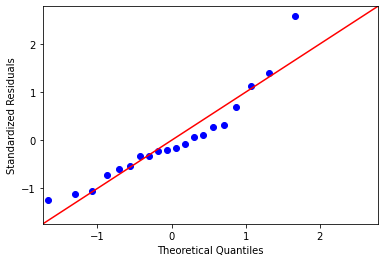

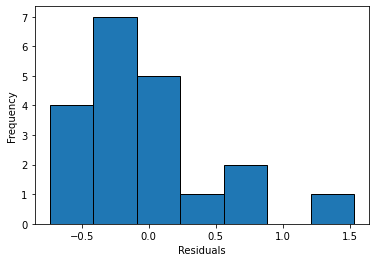

In [13]:
# QQplot 
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [14]:
# import scipy.stats as stats
# w, pvalue = stats.shapiro(model.resid)
# print(w, pvalue)
res.bartlett(df=df_result, res_var='value', xfac_var='treatments')
res.bartlett_summary

,Parameter,Value
0,Test statistics (T),3.2219
1,Degrees of freedom (Df),3.0000
2,p value,0.3587
